In [ ]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2
%matplotlib widget

from sklearn.neighbors import KernelDensity
from util import nab
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

# Load data
data_folder = '../data/nab'
file_name = 'realKnownCause/nyc_taxi.csv'
data, labels, windows = nab.load_series(file_name, data_folder)

# Train and validation end
train_end = pd.to_datetime('2014-10-24 00:00:00')
val_end = pd.to_datetime('2014-12-10 00:00:00')

# Cost model parameters
c_alrm = 1 # Cost of investigating a false alarm
c_missed = 10 # Cost of missing an anomaly
c_late = 5 # Cost for late detection

# Compute the maximum over the training set
trmax = data[data.index < train_end]['value'].max()
# Normalize
data['value'] = data['value'] / trmax
# Separate the training data
data_tr = data[data.index < train_end]

# Compute the bandhwidth
q1 = data_tr['value'].quantile(0.25)
q3 = data_tr['value'].quantile(0.75)
sigma = data_tr['value'].std()
m =  len(data_tr)
h = 0.9 * min(sigma, (q3-q1) / 1.34) * m**(-0.2)
print(f'KDE bandwidth: {h}')

# Build and fit a density estimator
print('Fitting a KDE estimator')
kde = KernelDensity(kernel='gaussian', bandwidth=h)
kde.fit(data_tr)

# Obtain the log probability density for all the data
print('Generating the alarm signal')
ldens = kde.score_samples(data)
# Convert to a pandas series (add the time index)
signal = pd.Series(index=data.index, data=-ldens)

# Build a cost model
cmodel = nab.ADSimpleCostModel(c_alrm, c_missed, c_late)

# Separate train & validation set (for threshold optimization)
signal_opt = signal[signal.index < val_end]
labels_opt = labels[labels < val_end]
windows_opt = windows[windows['end'] < val_end]
thr_range = np.linspace(0, 10, 100)

# Threshold optimization
print('Optimizing the threshold')
best_thr, best_cost = nab.opt_thr(signal_opt, labels_opt,
                                  windows_opt,  cmodel, thr_range)
print(f'Best threshold: {best_thr}')
print(f'Cost on the training set: {best_cost}')
ctst = cmodel.cost(signal, labels, windows, best_thr)
print(f'Cost on the whole dataset {ctst}')

# A Time-Dependent Estimator

## Looking More Closely

**Let us look again at our (normalized) data:**

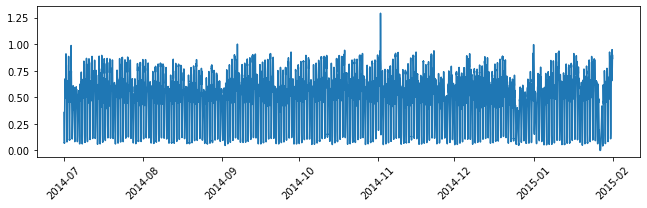

In [2]:
nab.plot_series(data)

* There is a recurring pattern!
* Can we take advantage of that?

## Analyzing the Pattern

**Our signal is almost periodic**

...I.e. the pattern is _time-based_

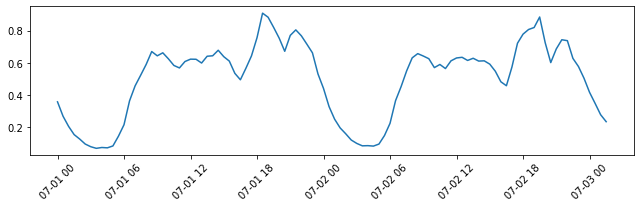

In [3]:
nab.plot_series(data.iloc[:100])

## Determine the Period

**How to determine the period of a series?**

A useful tool: _autocorrelation plots_

* Consider a range of possible _lags_
* For each lag value $l$:
  - Make a copy of the series and shift it by $l$ time steps
  - Compute the [Pearson Correlation Coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) with the original series
* Plot the correlation coefficients over the lag values

**Then we look at the resulting plot:**

* If there are peaks corresponding to existing periods
* Positive peaks denote strong correlations
* Negative peaks denote strong negative correlations

## Determine the Period

**Let's see an autocorrelation plot for our data:**

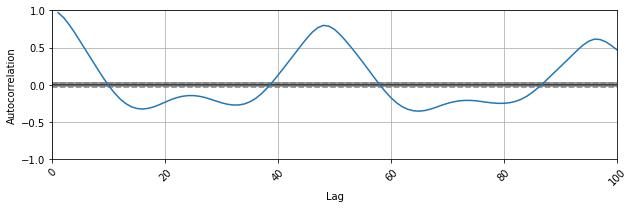

In [4]:
nab.plot_autocorrelation(data, max_lag=100)

* There is _strong peak at 48_
* A time step is 30 minutes $\Rightarrow$ there is a period of _24 hours_
* We will disregard the horizontal bars

## Multivariate-Distribution

**One way to look at that:**

* The distribution depends on the time of the day
* Equivalently: our $x$ variable has _two components_
  - The first component $x_1$ is the time of the day
  - The second component $x_2$ is the value
 
**Let us extract (from the index) this new information:**

In [5]:
dayhour = (data.index.hour + data.index.minute / 60)
dayhour = dayhour / 23.5 # normalize

We can then add it as a separate column to the data:

In [6]:
data2 = data.copy()
data2['dayhour'] = dayhour

## Multivariate Distribution

**Let us examine the resulting multivariate distribution**

We can use a 2D histogram:

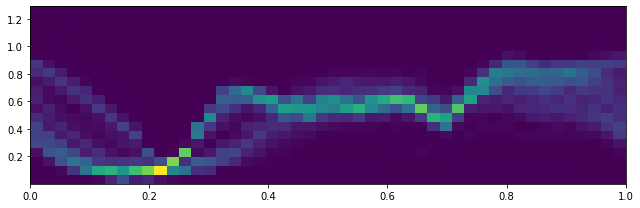

In [7]:
nab.plot_histogram2d(data2['dayhour'], data2['value'], bins=(48, 20))

* x = time, y = value, color = frequency of occurrence

## Multivariate Distribution

**The distribution of the time component is uniform:**

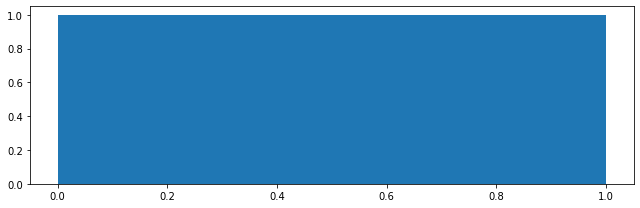

In [8]:
nab.plot_histogram(data2['dayhour'], bins=48)

## Time-Dependent Estimator

**We can use this information to build a time-dependent estimator**

When we run the the estimator:

* The time component (i.e. $x_1$) is _completely predictable_
* The value component (i.e. $x_2$) may be anomalous

**Hence, we can define our anomaly condition as:**

$$
P(x_2 \mid x_1) \leq \theta
$$

Using the definition of conditional probability:

$$
\frac{P(x_2, x_1)}{P(x_1)} \leq \theta
$$

## Time-Dependent Estimator

**However, since $P(x_1)$ is uniform**

...It can be incorporated in the threshold:
$$
P(x_2, x_1) \leq \theta^\prime
$$

Where $\theta^\prime = \theta P(x_1)$


**KDE cannot learn natively conditional probabilities**

If we need to use them anyway, there are two strategies:

* Using the Bayes theorem (like we did)
  - In the general case, we will need a second estimator for $P(x_1)$
* If $x_1$ is _discrete_, we can learn a KDE estimator for each $x_1$ value


## Bandwidth Choice in Multivariate KDE

**We now need to learn our multivariate KDE estimator**

First, we need to choose a bandwidth

* We cannot use the (univariate) rule of thumb
* ...But we can use another technique

**Let $\tilde{x}$ be a _validation_ set of $m$ examples:**

Assuming independent observations, its likelihood (estimated probability) is:

$$L(\tilde{\bf x}, \hat{\bf x}, h) = \prod_{i=1}^m f(\tilde{x}_i, \hat{\bf x}, h)$$

* $f$ is the estimator, $\hat{\bf x}$ the training set, $h$ is the bandwidth
* We can choose $h$ so as to _maximize the likelihood_!


## Bandwidth Choice in Multivariate KDE

**A simple approach consist in using grid search**

* It's the same approach that we used for optimizing the threshold
* scikit learn provides a convenient implementation
* ...Which resorts to cross-fold validation to define $\tilde{x}$

First, we build a grid search optimizer:

In [9]:
from sklearn.model_selection import GridSearchCV

# Build the grid search optimizer
params = {'bandwidth': np.linspace(0.001, 0.01, 10)}
opt = GridSearchCV(KernelDensity(kernel='gaussian'), params, cv=5)

* The first argument of `GridSearchCV` is the (type of) estimator
* The `params` dictionary specifies the range to be explored
* `cv = 5` specifies the number folds for cross-validation

## Bandwidth Choice in Multivariate KDE

**Next, we:**

* Separate the training set
* "Fit" the `GridSearchCV`, which will run the optimization loop

In [10]:
# Split training data
data2_tr = data2[data2.index < train_end]
opt.fit(data2_tr);

Not surprisingly, the process takes some time

**Then we can access the best parameters with:**

In [11]:
opt.best_params_

{'bandwidth': 0.006}

## Fitting the Estimator

**Finally, we can fit the estimator**

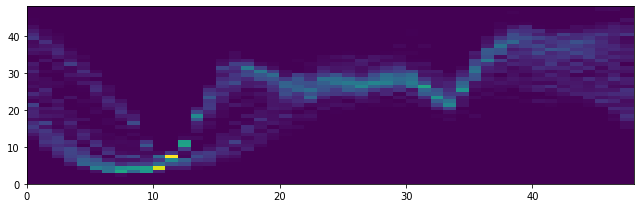

In [12]:
h = opt.best_params_['bandwidth']
kde2 = KernelDensity(kernel='gaussian', bandwidth=h)
kde2.fit(data2_tr)

xr = np.linspace(0, 1, 48)
yr = np.linspace(0, 1, 48)
nab.plot_density_estimator_2D(kde2, xr, yr)

## Alarm Signal

**Let us obtain the alarm signal**

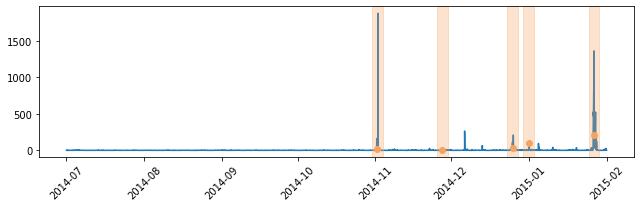

In [13]:
ldens2 = kde2.score_samples(data2)
signal2 = pd.Series(index=data2.index, data=-ldens2)
nab.plot_series(signal2, labels=labels, windows=windows)

## Effect of the Threshold

**Let us see the response surface w.r.t. the threshold**

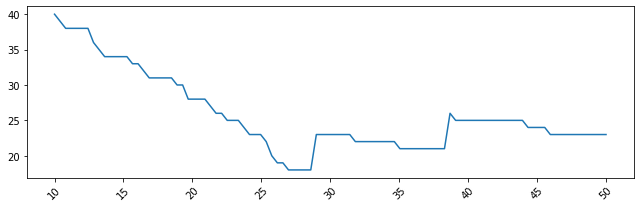

In [14]:
thr2_range = np.linspace(10, 50, 100)
cost2_range = [cmodel.cost(signal2, labels, windows, thr)
              for thr in thr2_range]
cost2_range = pd.Series(index=thr2_range, data=cost2_range)
nab.plot_series(cost2_range)

This is _considerably better_ than before!

## Threshold Optimization

**Now, let us optimize our threshold:**

In [15]:
signal2_opt = signal2[signal2.index < val_end]
best_thr2, best_cost2 = nab.opt_thr(signal2_opt, labels_opt,
                                  windows_opt,  cmodel, thr2_range)
print(f'Best threshold: {best_thr2}, corresponding cost: {best_cost2}')

Best threshold: 25.757575757575758, corresponding cost: 9


On the whole dataset:

In [16]:
c2tst = cmodel.cost(signal2, labels, windows, best_thr2)
print(f'Cost on the whole dataset {c2tst}')

Cost on the whole dataset 20


* It was 45 for the first approach and 37 for the second

## Considerations

**Time-dependencies in the data should be exploited**

* We always know what time it is: it's _free information_!
* Additional information can be used to improve our predictions
* In fact, our time dependent estimator is based on a _conditional_ probability

**_Open Problem:_ There is a second period in the data**

* Can you figure out which one?
* How to exploit it?

_If you wish_, you can investigate this at home

* There will be no evaluation
* ...But it's a good occasion to practice and learn